In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader,Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [95]:
def prep_data(x_dir,y_dir):
  x=np.load(x_dir)
  y=np.load(y_dir)

  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,shuffle=True,random_state=42)

  return x_train,x_test,y_train,y_test

In [96]:
x_train,x_test,y_train,y_test=prep_data("/content/drive/MyDrive/NYK/X.npy","/content/drive/MyDrive/NYK/y.npy")

In [97]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((4000, 784), (1000, 784), (4000,), (1000,))

In [98]:
class OurTrainData(Dataset):

  def __init__(self,x,y):
    super(OurTrainData,self).__init__()
    self.x=torch.tensor(x)
    self.y_t=torch.tensor(y)
    self.ohe=OneHotEncoder(sparse_output=False)
    #self.y=self.ohe.fit_transform(self.y_t.reshape(-1,1))

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, index) :
    x_sample=self.x[index].reshape(1,-1) / 255.0
    y_sample=self.y_t[index].reshape(1,-1)


    return x_sample,y_sample

  def get_ohe (self):
    return self.ohe

In [99]:
our_train_data=OurTrainData(x_train,y_train)

In [100]:
our_train_loader=DataLoader(our_train_data,shuffle=True,batch_size=32)

In [43]:

for x_b,y_b  in our_train_loader:
  #print(x_b.shape)
  print(y_b)

  break

tensor([[[8]],

        [[9]],

        [[7]],

        [[4]],

        [[5]],

        [[4]],

        [[6]],

        [[8]],

        [[9]],

        [[5]],

        [[7]],

        [[7]],

        [[0]],

        [[7]],

        [[7]],

        [[2]],

        [[4]],

        [[9]],

        [[4]],

        [[6]],

        [[2]],

        [[0]],

        [[1]],

        [[0]],

        [[3]],

        [[3]],

        [[6]],

        [[6]],

        [[5]],

        [[0]],

        [[8]],

        [[1]]])


In [44]:
y_train[:6]

array([7, 4, 9, 7, 8, 5])

In [45]:
for x_b,y_b  in our_train_loader:
  print(x_b.shape)
  print(y_b.shape)

  break

torch.Size([32, 1, 784])
torch.Size([32, 1, 1])


In [46]:
ohe_t=our_train_data.get_ohe()

In [101]:
class OurTestData(Dataset):

  def __init__(self,x,y,ohe_t):
    super(OurTestData,self).__init__()
    self.x=torch.tensor(x)
    self.y_t=torch.tensor(y)
    self.ohe=ohe_t
    #self.y=self.ohe.transform(self.y_t.reshape(-1,1))

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, index) :
    x_sample=self.x[index].reshape(1,-1) / 255.0
    y_sample=self.y_t[index].reshape(1,-1)


    return x_sample,y_sample



In [102]:
our_test_data=OurTestData(x_test,y_test,our_train_data.get_ohe())

In [103]:
our_test_loader=DataLoader(our_test_data,shuffle=False,batch_size=32)

In [50]:

for x_b,y_b  in our_test_loader:
  #print(x_b.shape)
  print(y_b)

  break

tensor([[[5]],

        [[9]],

        [[3]],

        [[7]],

        [[6]],

        [[2]],

        [[2]],

        [[7]],

        [[5]],

        [[3]],

        [[5]],

        [[1]],

        [[9]],

        [[8]],

        [[7]],

        [[2]],

        [[6]],

        [[0]],

        [[2]],

        [[2]],

        [[4]],

        [[0]],

        [[2]],

        [[5]],

        [[1]],

        [[5]],

        [[9]],

        [[6]],

        [[7]],

        [[5]],

        [[4]],

        [[3]]])


In [119]:
y_test[:6]

array([5, 9, 3, 7, 6, 2])

In [51]:
for x_b,y_b  in our_test_loader:
  print(x_b.shape)
  print(y_b.shape)

  break

torch.Size([32, 1, 784])
torch.Size([32, 1, 1])


In [104]:
class OurModel(nn.Module):

  def __init__(self,input_dim,output_dim):
    super(OurModel,self).__init__()

    self.input_dim=input_dim
    self.output_dim=output_dim
    self.l1=nn.Linear(self.input_dim,20)
    self.l2=nn.Linear(20,15)
    self.l3=nn.Linear(15,self.output_dim)

    self.tanh_act=nn.Tanh()

  def forward(self,x):

    x=self.l1(x)
    x=self.tanh_act(x)

    x=self.l2(x)
    x=self.tanh_act(x)

    x=self.l3(x)

    return x  #x.shape

In [123]:
our_model=OurModel(784,10)

In [124]:
print(our_model(torch.rand(2,1,784)))

torch.Size([2, 1, 10])


In [105]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [106]:
our_model=OurModel(784,10).to(device)

In [107]:
def our_accuracy (t,p):

  #t=torch.argmax(t,dim=1)

  p=torch.argmax(p,dim=1)

  t_v=torch.sum(t==p).item()

  return t_v / len(t)

In [19]:
#print(our_accuracy(torch.tensor([[3,5,8],[5,5,8]]),torch.tensor([[3,5,8],[5,5,8]])))

1.0


In [108]:
loss_f=nn.CrossEntropyLoss()  # The target data **should not** be one-hot encoded

optimizer=optim.SGD(our_model.parameters(),lr=1e-2)

train_loss_l=[]
test_loss_l=[]

for epoch in range (20):

      train_loss=0
      test_loss=0

      c_train=0
      c_test=0
      t_train=0
      t_test=0

      our_model.train()

      for x_batch , y_batch in our_train_loader:

          x_batch=x_batch.to(device).float().squeeze()
          y_batch=y_batch.to(device).long().squeeze()



          outputs=our_model(x_batch)

          loss=loss_f(outputs,y_batch)

          optimizer.zero_grad()

          loss.backward()

          optimizer.step()

          train_loss+=loss.item()

          c_train+=sum(torch.argmax(outputs,dim=1)==y_batch).item()
          t_train+=y_batch.shape[0]

      train_accuracy=c_train/t_train  #our_accuracy (y_batch,outputs)

      train_loss/=len(our_train_loader)

      train_loss_l.append(train_loss)
      our_model.eval()
      with torch.inference_mode():

            for x_batch_t , y_batch_t in our_test_loader:

                x_batch_t=x_batch_t.to(device).float().squeeze()
                y_batch_t=y_batch_t.to(device).long().squeeze()

                outputs_t=our_model(x_batch_t)

                loss_t=loss_f(outputs_t,y_batch_t)

                test_loss+=loss_t.item()

                c_test+=sum(torch.argmax(outputs_t,dim=1)==y_batch_t).item()

                t_test+=y_batch_t.shape[0]


            test_loss/=len(our_test_loader)

            test_accuracy=c_test/t_test    #our_accuracy (y_batch_t,outputs_t)

            test_loss_l.append(test_loss)

      print(f"at epoch = {epoch} >> train loss = {train_loss} and train accuracy = {train_accuracy} , test loss = {test_loss} and test accuracy = {test_accuracy}")

at epoch = 0 >> train loss = 2.2639678230285645 and train accuracy = 0.16225 , test loss = 2.1987405866384506 and test accuracy = 0.261
at epoch = 1 >> train loss = 2.134129648208618 and train accuracy = 0.34275 , test loss = 2.0534781739115715 and test accuracy = 0.425
at epoch = 2 >> train loss = 1.972663091659546 and train accuracy = 0.4665 , test loss = 1.8757136575877666 and test accuracy = 0.554
at epoch = 3 >> train loss = 1.7911044759750365 and train accuracy = 0.55425 , test loss = 1.6899843253195286 and test accuracy = 0.601
at epoch = 4 >> train loss = 1.6130007934570312 and train accuracy = 0.6035 , test loss = 1.5174251720309258 and test accuracy = 0.646
at epoch = 5 >> train loss = 1.4543968362808228 and train accuracy = 0.6475 , test loss = 1.3701989576220512 and test accuracy = 0.691
at epoch = 6 >> train loss = 1.3215448617935182 and train accuracy = 0.68175 , test loss = 1.2451165691018105 and test accuracy = 0.713
at epoch = 7 >> train loss = 1.2103169527053832 and t

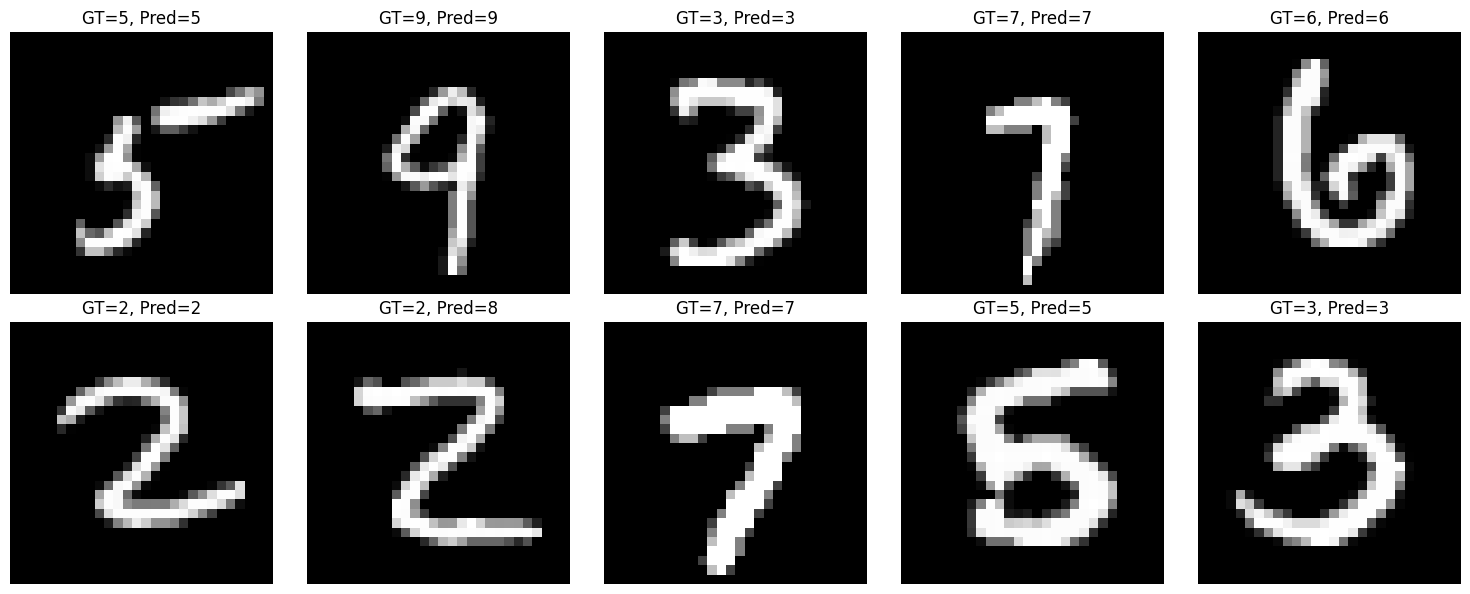

In [125]:
our_model.eval()
with torch.inference_mode():

        num_images = 10
        rows = int(np.ceil(num_images / 5))
        cols = 5

        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten()

        for i in range(num_images):
            p_p=our_model(torch.tensor(x_test[i]).float())
            t = y_test[i]
            p = torch.argmax(p_p)

            axes[i].imshow(x_test[i].reshape(28, 28), cmap='gray')
            axes[i].set_title(f"GT={t}, Pred={p}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()



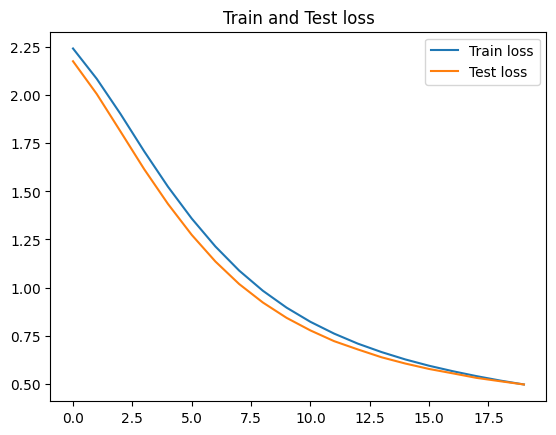

In [126]:
plt.plot(train_loss_l,label="Train loss")
plt.plot(test_loss_l,label="Test loss")
plt.title("Train and Test loss")
plt.legend()
plt.show()